## Importing required (obviously) packages

In [69]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
dataset='dataset'

### Loading images from the dataset and preprocessing

In [3]:
imgpaths=list(paths.list_images(dataset))
len(imgpaths)

4088

In [4]:
data=[]
labels=[]

In [5]:
#looping over all images

i=1
for img in imgpaths:
    label=img.split(os.path.sep)[1]
    
    print(i, end=' ')
    i+=1     #keeping a count. Waiting wihthout getting a glimpse of progress is frustrating
    #loading images and resizing
    image=load_img(img, target_size=(224,224))
    image=img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 

C:\Users\Saranga\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3423 3424 3425 3426 3427 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437 3438 3439 3440 3441 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475 3476 3477 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489 3490 3491 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 

In [6]:
#convert data and labels lists to numpy arrays
data=np.array(data)
labels=np.array(labels)
data

array([[[[ -85.939     , -113.779     , -116.68      ],
         [ -85.939     , -113.779     , -116.68      ],
         [ -85.939     , -113.779     , -116.68      ],
         ...,
         [ -75.939     , -104.779     , -104.68      ],
         [ -75.939     , -104.779     , -104.68      ],
         [ -74.939     , -103.779     , -103.68      ]],

        [[ -81.939     , -109.779     , -112.68      ],
         [ -81.939     , -109.779     , -112.68      ],
         [ -81.939     , -109.779     , -112.68      ],
         ...,
         [ -62.939003  ,  -90.779     ,  -93.68      ],
         [ -62.939003  ,  -90.779     ,  -93.68      ],
         [ -61.939003  ,  -89.779     ,  -92.68      ]],

        [[ -78.939     , -111.779     , -113.68      ],
         [ -78.939     , -111.779     , -113.68      ],
         [ -78.939     , -111.779     , -113.68      ],
         ...,
         [ -76.939     , -103.779     , -108.68      ],
         [ -74.939     , -101.779     , -106.68      ],
  

In [30]:
labels=[]

i=0

for img in imgpaths:
    label=img.split(os.path.sep)[1]
    
    print(i, end=' ')
    i+=1     #keeping a count. Waiting wihthout getting a glimpse of progress is frustrating
    #loading images and resizing
    
    
 
    labels.append(label)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 

In [32]:
#One-hot encoding labels
from sklearn.preprocessing import LabelBinarizer as LB

lb = LB()
labels = lb.fit_transform(labels)

In [49]:
labels = to_categorical(labels)
labels.shape

(4088, 2)

In [50]:
labels[4087]

array([1., 0.], dtype=float32)

In [51]:
labels[0]

array([0., 1.], dtype=float32)

## Spliiting data into train and test sets

In [53]:
from sklearn.model_selection import train_test_split as TTS

(X_train, X_test, y_train, y_test)=TTS(data,labels,test_size=0.2, random_state=7)

## Data Augmentation

In [40]:
aug=ImageDataGenerator(
    rotation_range=12,
    zoom_range=7,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'   
)

## Transfer learning (VGG19)

In [41]:
base_model = VGG19(weights="imagenet", include_top=False, input_tensor=(Input(shape=(224,224,3))))

In [42]:
head_model=base_model.output
head_model=Flatten()(head_model)
head_model=Dense(128, activation='relu')(head_model)
head_model=Dropout(0.3)(head_model)
head_model=Dense(2,activation='softmax')(head_model)

In [43]:
model=Model(inputs=base_model.input, outputs=head_model)

In [44]:
for layer in base_model.layers:
    layer.trainable=False
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [56]:
optimizer=Adam(lr=0.0001)
epochs=5
batch_size=16

In [57]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [60]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3270, 224, 224, 3)
(3270, 2)
(818, 224, 224, 3)
(818, 2)


In [61]:
history=model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size), 
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//batch_size,
    epochs=epochs
        )

Epoch 1/5
204/204 [==============================] - 185s 905ms/step - loss: 1.8766 - accuracy: 0.7366 - val_loss: 0.2494 - val_accuracy: 0.9523
Epoch 2/5
204/204 [==============================] - 180s 881ms/step - loss: 0.4886 - accuracy: 0.8390 - val_loss: 0.1825 - val_accuracy: 0.9645
Epoch 3/5
204/204 [==============================] - 181s 888ms/step - loss: 0.3706 - accuracy: 0.8482 - val_loss: 0.2079 - val_accuracy: 0.9560
Epoch 4/5
204/204 [==============================] - 182s 892ms/step - loss: 0.3639 - accuracy: 0.8577 - val_loss: 0.1862 - val_accuracy: 0.9511
Epoch 5/5
204/204 [==============================] - 186s 910ms/step - loss: 0.2813 - accuracy: 0.8774 - val_loss: 0.1025 - val_accuracy: 0.9743


In [63]:
preds=model.predict(X_test, batch_size=batch_size)

In [65]:
outputs=np.argmax(preds, axis=1)
outputs

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), outputs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       432
without_mask       0.98      0.96      0.97       386

    accuracy                           0.97       818
   macro avg       0.98      0.97      0.97       818
weighted avg       0.97      0.97      0.97       818



### Got an amazing result, hence storing the model

In [73]:
model.save('model.h5')

In [75]:
from keras.models import load_model


x=load_model('model.h5')

In [77]:
preds=x.predict(X_test, batch_size=batch_size)
x_outputs=np.argmax(preds, axis=1)
y=x_outputs-outputs
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Visualizing training and validation accuracy and loss

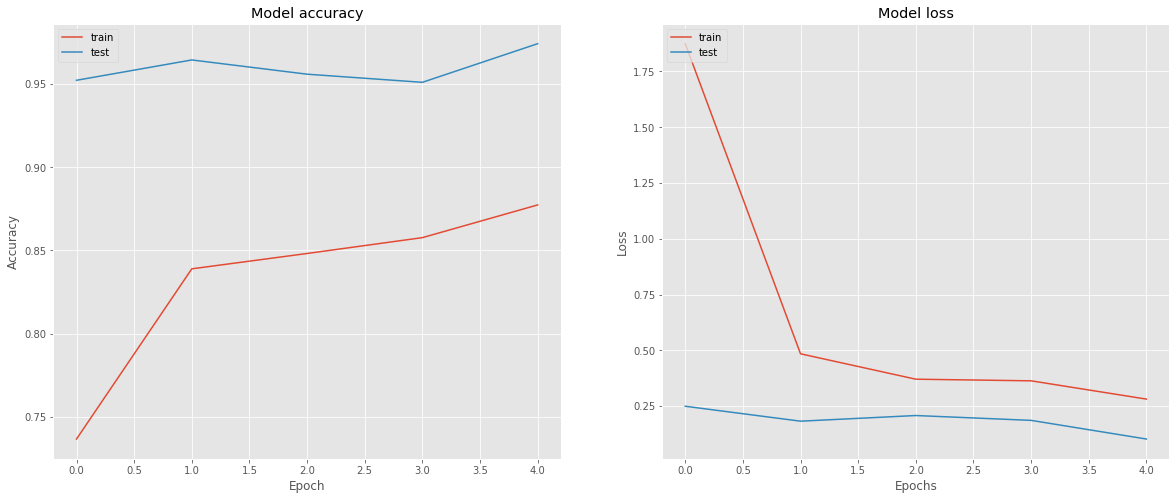

In [94]:
plt.figure(figsize=(20,8))

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig('Model_training_history.png')